<a href="https://colab.research.google.com/github/billyaja/Investigating-SAT-Scores/blob/main/Schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

# Read in the data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [ ]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

<ipython-input-3-630d40a9059d>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [ ]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [ ]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [ ]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [ ]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [ ]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

<ipython-input-8-8b9a77ecc7f2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [ ]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [ ]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.987051
SAT Math Avg. Score                0.973412
SAT Writing Avg. Score             0.987542
sat_score                          1.000000
AP Test Takers                     0.520593
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.085032
lon                               -0.071170
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [ ]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

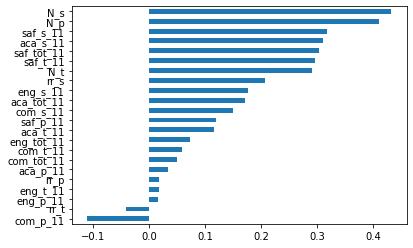

In [ ]:
%matplotlib inline
pd.concat([combined[survey_fields], combined['sat_score']], axis=1).corr()['sat_score'].sort_values()[:-1].plot(kind='barh')

We see that `aca_s_11` and `saf_s_11` have a high correlation with sat_score. In the data dictionary, `aca_s_11` is academic expectations score based on student responses. It is surprising to find that `saf_s_11`, safety and respect score based on student responses, has a strong correlation with sat_score. We will dig a bit more into this relationship.

## Exploring Safety and SAT Scores

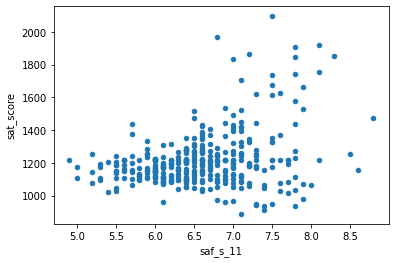

In [ ]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

We can see that safety score above 7 has a positive correlation with SAT_score but not really that strong. It seems that there are few schools with high safety scores that have high SAT scores and few schools with low safety scores have low SAT scores. There are no schools with a safety score below 6.5 that have an SAT score greater than 1500.

In [ ]:
combined.groupby('boro').mean()['saf_s_11'].sort_values(ascending=False)

boro
Manhattan    6.831209
Queens       6.688525
Bronx        6.606499
Brooklyn     6.347000
Name: saf_s_11, dtype: float64

Manhattan and Queens tend to have higher safety scores.

## Exploring Race and SAT Scores

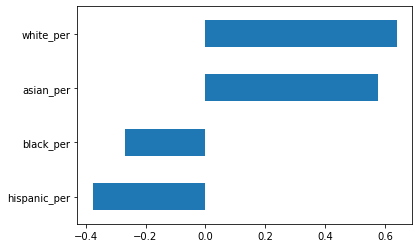

In [ ]:
races_with_sat = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
combined[races_with_sat].corr()['sat_score'].sort_values()[:-1].plot(kind='barh')

White people tend to have higher SAT scores than Asians, which is perhaps to be expected. It is surprising to see that Hispanics have lower SAT scores than blacks. We will explore more about the relationship between Hispanic race and SAT score by scatter plot.

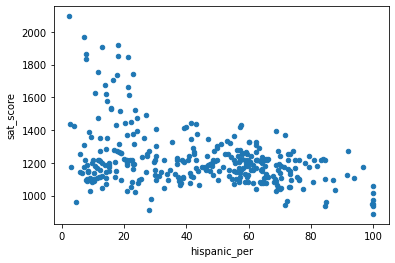

In [ ]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Hispanic percentage negatively correlated with SAT score, in other words schools that have a high percentage of Hispanic tend to have lower SAT scores. Now, I will try to research schools that have greater than 95% Hispanic students.

In [ ]:
combined[combined['hispanic_per'] > 95].sort_values(by='sat_score')['SCHOOL NAME']

253                            MULTICULTURAL HIGH SCHOOL
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
Name: SCHOOL NAME, dtype: object

Taking a look at Google, these schools are primarily for people who are new immigrants. The schools focus on helping students learn English, which is why they tend to have lower SAT scores. Now, we will try to find schools that have less than 10% Hispanic students. 

In [ ]:
combined[combined['hispanic_per'] < 10].sort_values(by='sat_score', ascending=False)['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
187                       BROOKLYN TECHNICAL HIGH SCHOOL
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
194                            BENJAMIN BANNEKER ACADEMY
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
192                          BEDFORD ACADEMY HIGH SCHOOL
236                             CLARA BARTON HIGH SCHOOL
335                              CAMBRIA HEIGHTS ACADEMY
332                    EXCELSIOR PREPARATORY HIGH SCHOOL
280          BROOKLYN COLLEGIATE: A COLLEGE BOARD SCHOOL
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
331    PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
337                 HUMANITIES & ARTS MAGNET HIGH SCHOOL
238                           B

Many of the schools appeared to specialize in science and technology. These schools appear to have received extra funding.

## Gender and SAT Scores

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

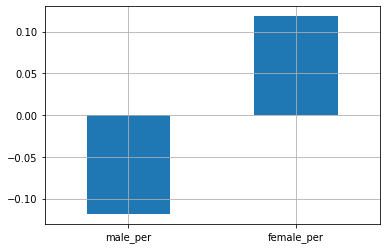

In [ ]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot(kind='bar')
plt.grid(True)
plt.xticks(rotation=0)

It is surprising that the male percentage negatively correlated with SAT scores. Instead, female percentage positively correlated with SAT scores, exactly opposite of male percentage. 
We will dig more about the female percentage.

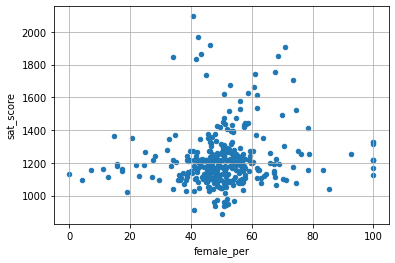

In [ ]:
combined.plot.scatter('female_per', 'sat_score')
plt.grid(True)
plt.show()

There seems no correlation between female percentage and SAT scores, however there is a cluster of schools with majority female (60, 80) have high SAT scores.

In [ ]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)].sort_values(by='sat_score', ascending=False)['SCHOOL NAME']

302                          TOWNSEND HARRIS HIGH SCHOOL
5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
Name: SCHOOL NAME, dtype: object

Taking a look at Wikipedia, these schools appear to be competitive schools with high academic standards.

## AP Scores vs. SAT scores

In [ ]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

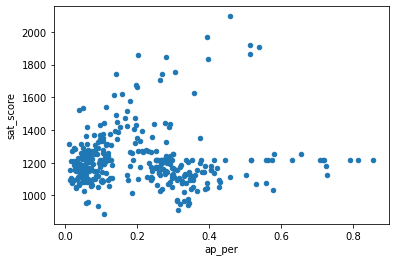

In [ ]:
combined.plot.scatter('ap_per', 'sat_score')
plt.show()

There is a weak correlation between SAT scores and ap_per.